In [47]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Pool
from functools import partial
from copy import deepcopy
import time, os, sys

from sklearn import linear_model, metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor, VotingRegressor, AdaBoostRegressor, BaggingRegressor

import pickle
from scipy import stats 

# 
import mkl
mkl.set_num_threads(1)
nCPU= 30
N=5

%matplotlib inline

In [2]:
print(pd.__version__)

1.3.4


In [3]:
file = '/public/home/test1/mydata/proteome/data/20210414_dict_matrix_17dataset.pkl'
file = '/media/eys/xwj/proteome/data/20211022_dict_matrix_20dataset.pkl'
with open(file, 'rb') as f:
    [ dict_dataset, df_summary]=pickle.load(f)

In [4]:
### Prediction of RNA to protein in brain tissue

file = '/public/home/test1/mydata/proteome/data/RNA_before_pred.pkl'
with open(file, 'rb') as f:
    [ brain_atlas_RNA ]=pickle.load(f)

In [5]:
brain_atlas_RNA.shape

(14729, 231)

In [34]:
## brain X and Y , because only some genes are common between training and test datasets
## overlapping genes~ 13000/14000
common = dict_dataset[mykey]["RNA"].index.intersection( brain_atlas_RNA.index )

print(dict_dataset[mykey]["RNA"].shape, brain_atlas_RNA.shape, len(common))

X = dict_dataset[mykey]["RNA"].loc[common].transform(lambda x: (x-x.mean())/x.std(), axis=1).round(3).transpose()
Y = dict_dataset[mykey]["protein"].transform(lambda x: (x-x.mean())/x.std(), axis=1).round(3).transpose()

## brain atlas
X_test = brain_atlas_RNA.loc[common].transform(lambda x: (x-x.mean())/x.std(), axis=1).round(3).transpose()

X_use, Y_use = X, Y
print(mykey, X.shape, Y.shape, X_test.shape,  X_use.shape,   Y_use.shape)

my_list_topn = list_topn + [X.shape[1]]
print(my_list_topn)

(14408, 71) (14729, 231) 13367
brain_71_2017_labelfree (71, 13367) (71, 4385) (231, 13367) (71, 13367) (71, 4385)
[10, 20, 50, 100, 200, 500, 1000, 5000, 13367]


In [41]:
## make an empty Y_test, the pipeline must need ONE
Y_test = pd.DataFrame( index = X_test.index, columns= Y.columns)
print(mykey, X.shape, Y.shape, X_test.shape, Y_test.shape, X_use.shape,   Y_use.shape)

brain_71_2017_labelfree (71, 13367) (71, 4385) (231, 13367) (231, 4385) (71, 13367) (71, 4385)


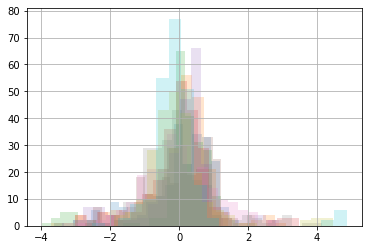

In [35]:
# data distribution is ok
for i in range(100,110,1):
    X_test.iloc[:, i].hist(bins=20, alpha=0.2)

In [6]:
file = '/media/eys/xwj/proteome/data/df_metric_list_topn_20220104.pkl'
with open(file, 'rb') as f:
    [ df_metric_list_topn, df_metric_list_topn2 ]=pickle.load(f)

In [36]:
mykey='brain_71_2017_labelfree'
df_metric_list_topn.loc[ (mykey,'Voting'), ('cosine', 'r')].idxmax(), \
df_metric_list_topn.loc[ (mykey,'Voting'), ('cosine', 'rmse')].idxmin(), \
df_metric_list_topn.loc[ (mykey,'Voting'), ('cosine', 'mae')].idxmin(), \
## best topn is 5000,  use 1000 gene should be fine

/public/home/test1/soft/anaconda3/envs/py3.7.3_skorch/lib/python3.7/site-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


(5000, 'All', 'All')

In [33]:

model_dict = {
    "LR": linear_model.LinearRegression(), 
    "Lasso": linear_model.Lasso(alpha=0.02, max_iter=1e5), 
    "HR": linear_model.HuberRegressor(), #Linear regression model that is robust to outliers.
    "Ridge": linear_model.Ridge(), 
    "SVR": SVR( gamma='scale'),
    "RFR": RandomForestRegressor(n_estimators=100, max_depth=3, random_state=0), 
    # NN : construct later, because feature length have to be set 
    "NN1": None,
    "NN2": None,
    "NN3": None,
    ##### other ensemble models
    "Stacking": None,
    "Voting": None,
    "Boosting": None,
    "Bagging": None, 
    ##### reimplement published methods
    "baselineEN": linear_model.ElasticNet(l1_ratio = 0.5, random_state = 0, precompute=True), 
    "teamHYU": RandomForestRegressor(n_estimators=100, random_state=0), # Author not providing detail, use default
    "teamHL&YG": None, ## equivalent to RFR without feature selection
    }

basic_estimators = [
    ("LR",  model_dict['LR']), 
    ("Lasso", model_dict['Lasso']), 
    ("HR",  model_dict['HR']),
    ("Ridge", model_dict['Ridge']), 
    ("SVR", model_dict['SVR']),
    ("RFR", model_dict['RFR']), 
    ]
 
model_dict['Stacking'] = StackingRegressor(estimators=basic_estimators)
model_dict['Voting'] = VotingRegressor(basic_estimators)
model_dict['Boosting']  = AdaBoostRegressor(random_state=0)
model_dict['Bagging'] = BaggingRegressor(random_state=0)
    
list_model = list(model_dict.keys())
print( model_dict, list_model )
method_feature_select = ["cosine", "raw_cosine", "spearmanr", "random", "custom"]

# feature numbers to be prioritized in feature selection 
list_topn = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 200, 1000, 5000 ] # v1
list_topn = [5, 10, 20, 30, 40, 50, 100, 200, 500, 1000, 5000 ] # v2
list_topn = [10, 20, 50, 100, 200, 500, 1000, 5000  ] # v3

#############
def create_res(list_topn):
    res = {}
    for mfs in method_feature_select:
        res[mfs] = {} 
        for topn in list_topn:
            # summary table
            res[mfs][topn] = {}
            res[mfs][topn]["time"] = pd.DataFrame(data = 0, dtype = np.int32, index = model_dict, columns= ["val","train","test"])
            # detail data for all models
            for m in model_dict:
                res[mfs][topn][m]={}
                res[mfs][topn][m]["y_pred_CVtrain"], res[mfs][topn][m]["y_pred_CVtest"] ={}, {}
    return res

# comp_y_pred only output y_predict value
def comp_y_pred(p): ### this function fit a classical machine learning model and pred y value
    # usage: comp_y_pred("ENSG00000000419") 
    select=X_train.columns[ df_topn[p] ]
    X_val_select, X_train_select, y_val, y_train = X_val[select], X_train[select], Y_val[p], Y_train[p]
    my_model=model_dict[m].fit(X_train_select, y_train) #'''fit model with selected features'''
    # training fit and test fit
    return my_model.predict(X_train_select), my_model.predict(X_val_select)

{'LR': LinearRegression(), 'Lasso': Lasso(alpha=0.02, max_iter=100000.0), 'HR': HuberRegressor(), 'Ridge': Ridge(), 'SVR': SVR(), 'RFR': RandomForestRegressor(max_depth=3, random_state=0), 'NN1': None, 'NN2': None, 'NN3': None, 'Stacking': StackingRegressor(estimators=[('LR', LinearRegression()),
                              ('Lasso', Lasso(alpha=0.02, max_iter=100000.0)),
                              ('HR', HuberRegressor()), ('Ridge', Ridge()),
                              ('SVR', SVR()),
                              ('RFR',
                               RandomForestRegressor(max_depth=3,
                                                     random_state=0))]), 'Voting': VotingRegressor(estimators=[('LR', LinearRegression()),
                            ('Lasso', Lasso(alpha=0.02, max_iter=100000.0)),
                            ('HR', HuberRegressor()), ('Ridge', Ridge()),
                            ('SVR', SVR()),
                            ('RFR',
                           

In [51]:
run_cross_validation = False
run_test = True
list_model_done = [ ]
print(time.ctime(), 'nCPU =', nCPU, 'run_cross_validation=', run_cross_validation, 'run_test=', run_test)
outfile = '/public/home/test1/mydata/proteome/data/res_v4.3_' +time.strftime("%Y%m%d-%H%M")+\
    '_temp_'+ mykey + '.pkl'
print(outfile)
########### 1. load and transform data 

my_list_topn = [X.shape[1]] + list_topn[::-1] 
print(time.ctime(), mykey, 'X',  X.shape, 'Y', Y.shape,  my_list_topn)

df_template = pd.DataFrame(index= Y.columns, columns= range(N))
res = create_res(my_list_topn)

########### 2. Pre-comput feature ranking by feature selection methods 1~4
#rank RNAs by linear correlation, run once for the data set, use the matrix later, N-fold CV split i have its own feature ranking matrix
dict_feature_rank = dict.fromkeys(method_feature_select[:-1])
for mfs in dict_feature_rank:
    dict_feature_rank[mfs] = {'CV': dict.fromkeys(range(N)), 'test': dict.fromkeys(range(N))}

df_template = pd.DataFrame(index= Y.columns, columns= range(N))
res = create_res(my_list_topn)

## first, new machine learning models by me
############## 1. rank all features by a method, run once for the data set, use the maxtrix later
if run_test == True:
    print(time.ctime(), "prepare test set.")
    cos = pd.DataFrame(data=metrics.pairwise.cosine_similarity(X=X.transpose(), Y=Y.transpose(), 
                                                           dense_output=True), columns=Y.columns)
    dict_feature_rank['cosine']['test'] = abs(cos).rank(axis=0, ascending=False, method='first').astype(np.int32)
    
##### 2. cross-validaton model fit and evaluate with test
########### 3. Classical machine learning models using prioritized features
for mfs in ['cosine']: #method_feature_select[ :-1]:
    for topn in [1000, 5000]: #my_list_topn:
        for m in ['Voting']: #list_model[ :-3]:
            if (topn == X.shape[1] ) & (mfs !='cosine'): ### avoid recomputing all features, 
                res[mfs][topn][m] = deepcopy( res['cosine'][topn][m])
                continue
            print(time.ctime(), mfs.ljust(8,'-'), str(topn).ljust(8,'-'), m.ljust(10,'-'), end=":  ")
            
            if run_test:
                start =time.time()
                X_train, X_val = X, X_test
                Y_train, Y_val = Y, Y_test

                df_topn = ( dict_feature_rank[mfs]['test'] <= topn ) ## feature selection
                
                with Pool(nCPU) as pool:
                    print(nCPU)
                    y_pred_in_rows = []
                    temp = pool.map_async(comp_y_pred, Y_train.columns,  callback=y_pred_in_rows.extend)
                    temp.wait()
                    y_pred_train_in_rows, y_pred_val_in_rows = zip(*y_pred_in_rows)
                ## store y_pred
                res[mfs][topn][m]["y_pred_test"] = y_pred_val_in_rows
                res[mfs][topn][m]["y_pred_train"] = y_pred_train_in_rows
                res[mfs][topn]["time"].loc[m, "test"] =  int(time.time() - start) 
                
            list_model_done.extend([ m ])
            with open(outfile, 'wb') as f: 
                pickle.dump( [res],  f)
            print("done.")
            
list_model_done = [m for m in list_model if m in list_model_done]
outfile = '/public/home/test1/mydata/proteome/data/res_v4.3_' +time.strftime("%Y%m%d-%H%M")+    '_'+'-'.join(list_model_done)+'_'+ mykey + '.pkl'
with open(outfile, 'wb') as f: 
    pickle.dump( [res],  f)
print(time.ctime(), "complete", outfile)

Fri Jan  7 21:38:56 2022 nCPU = 30 run_cross_validation= False run_test= True
/public/home/test1/mydata/proteome/data/res_v4.3_20220107-2138_temp_brain_71_2017_labelfree.pkl
Fri Jan  7 21:38:56 2022 brain_71_2017_labelfree X (71, 13367) Y (71, 4385) [13367, 5000, 1000, 500, 200, 100, 50, 20, 10]
Fri Jan  7 21:38:56 2022 prepare test set.
Fri Jan  7 21:39:02 2022 cosine-- 1000---- Voting----:  30
done.
Fri Jan  7 21:42:12 2022 cosine-- 5000---- Voting----:  30
done.
Fri Jan  7 21:56:02 2022 complete /public/home/test1/mydata/proteome/data/res_v4.3_20220107-2156_Voting_brain_71_2017_labelfree.pkl


In [58]:
y_pred_test = pd.DataFrame(res[mfs][topn][m]["y_pred_test"], index= Y_train.columns, columns=X_test.index)

In [60]:
file="/media/eys/xwj/proteome/data/df_protein_predicted_brainatlas"+ mykey+ "%s.xlsx" % time.strftime("%Y%m%d")
with pd.ExcelWriter(file, mode='w') as writer: 
    ## original RNA profiles
    brain_atlas_RNA.to_excel(writer, sheet_name='brain_atlas_RNA' )
    ### predicted protein profile result
    y_pred_test.to_excel(writer, sheet_name='pred_by_'+mykey )

In [62]:
print(mfs, topn, m)
y_pred_test

cosine 5000 Voting


sample_name,S010002,S010003,S010006,S010007,S010017,S010021,S010034,S010035,S010044,S010046,...,S020448,S020492,S020495,S020555,S020560,S020562,S020656,S020671,S020697,S020722
ENSG00000000419,-0.065661,0.121245,0.072144,-0.261557,0.396354,-0.231029,0.417294,0.464590,-0.181127,0.179913,...,-0.024240,-0.078221,0.440084,-0.015687,0.350751,-0.129746,-0.833556,-1.056170,-0.842833,-0.957920
ENSG00000000971,0.045746,-0.284783,-0.094662,0.040904,0.099710,-0.076298,-0.592523,-0.171447,0.062105,-0.142362,...,-0.566994,-0.890966,-0.755587,0.262228,-0.378809,-0.861979,0.920954,0.982397,0.991599,0.780500
ENSG00000001084,0.260922,0.163857,-0.129365,-0.320284,0.031953,0.500173,-0.272144,-0.221043,0.193509,-0.354602,...,0.008216,-0.448634,-0.528865,1.149949,1.058553,-0.648198,-1.788100,-1.378046,-1.150940,-1.444326
ENSG00000001561,0.650607,0.161589,0.817700,1.035660,0.158322,0.439346,-0.237918,-0.038107,0.026042,-0.037303,...,-0.624667,-0.737336,-0.931410,0.018884,-0.192389,-0.931205,-2.263456,-2.229748,-2.057440,-2.154113
ENSG00000001629,0.264622,0.428375,0.227309,0.155297,0.688891,0.600820,0.880902,0.802693,0.636837,0.582517,...,-0.280222,0.276196,-0.158796,-1.432054,-0.759790,0.237514,-0.555512,-0.471963,-0.572709,-0.531192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000277363,0.484906,0.113828,0.190436,0.336553,0.192715,0.555451,0.262029,0.265669,0.312289,0.210727,...,-0.198949,-0.477678,-0.808870,-0.070302,-0.580827,-0.536488,0.700610,0.499506,0.749692,0.669856
ENSG00000277443,0.021876,-0.202222,-0.043727,0.264475,0.235200,-0.143440,0.070518,-0.161789,0.002162,0.186490,...,-0.402964,-0.132596,-0.131425,-0.554127,-1.096666,-0.031763,2.616940,2.340987,2.554846,2.547615
ENSG00000277586,0.678800,0.495665,-0.143843,0.076956,-0.270272,0.321970,-0.698347,-0.852038,-0.160584,-0.465839,...,0.038311,-0.370473,-0.607690,1.544494,0.898343,-0.525598,-1.659769,-1.349344,-1.336161,-1.692258
ENSG00000277791,0.041465,-0.363506,0.573067,0.407246,0.412800,-0.384949,0.363280,0.532473,-0.295805,0.458752,...,-0.403503,-0.421783,-0.904271,-1.277726,-1.238096,0.043569,1.331203,0.485969,0.983241,0.992514
